# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [103]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import plotly.express as px #для визуализации
from scipy.stats import normaltest
from sklearn import metrics
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [104]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [105]:
# Выведем общую информацию о датасете

churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


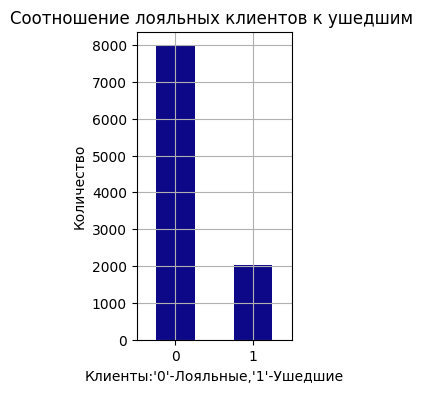

In [106]:
# Посмотрим на распределение признака оттока клиентов

data=churn_data['Exited'].value_counts()
data.plot(
    kind='bar',
    grid=True,
    figsize=(2, 4),
    colormap='plasma',
    title='Соотношение лояльных клиентов к ушедшим ',
    rot=0,
    xlabel="Клиенты:'0'-Лояльные,'1'-Ушедшие",
    ylabel='Количество'  
);

##### Вывод: Соотношение лояльных банку клиентов к ушедшим составляет 4:1 или в процентном выражении 80%:20%.

In [107]:
# Разделим признаки на категориальные и числовые

cat_feat = churn_data.select_dtypes(include = 'object')
num_feat = churn_data.select_dtypes(exclude = 'object')

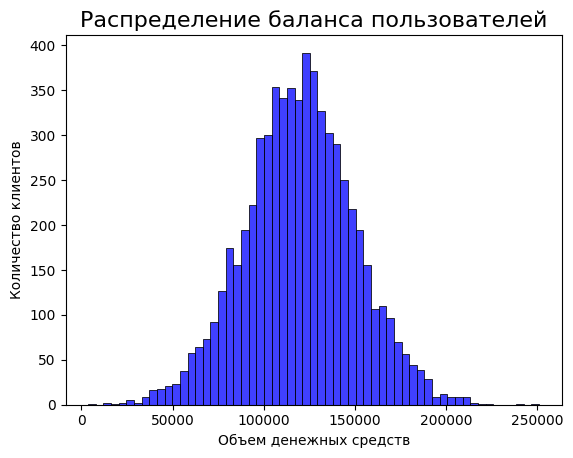

In [108]:
# Посмотрим на распределение баланса

data=churn_data[churn_data['Balance']>2500]
hist_1=sns.histplot(
    data=data,
    x='Balance',
    color='Blue',);
hist_1.set_title('Распределение баланса пользователей',fontsize=16)
hist_1.set_xlabel('Объем денежных средств')
hist_1.set_ylabel('Количество клиентов');

##### Вывод: У наибольшего количества вкладчиков на счетах находится суммы от 100 до 150 тысяч.

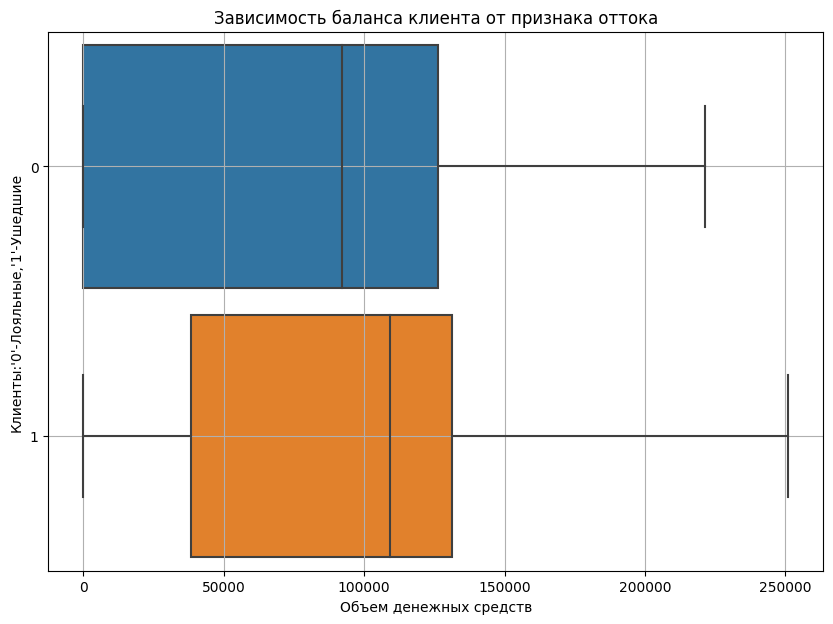

In [109]:
# Посмотрим на зависимость баланса от оттока клиентов

fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=churn_data,
    y='Exited',
    x='Balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Зависимость баланса клиента от признака оттока');
boxplot.set_xlabel('Объем денежных средств');
boxplot.set_ylabel("Клиенты:'0'-Лояльные,'1'-Ушедшие");
boxplot.grid()

##### Вывод: Видим, что отток клиентов не зависит от объема денежных средств на счетах. Вполне возможно, что банк предлагает более низкий процент по вкладам, чем в других банках.

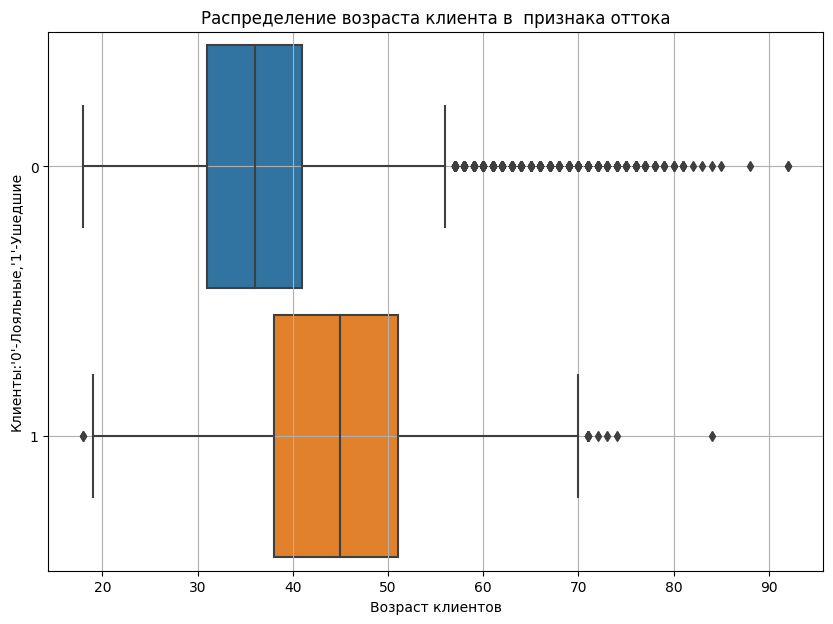

In [110]:
# Посмотрим на зависимость оттока от возраста клиента

fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=churn_data,
    y='Exited',
    x='Age',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение возраста клиента в  признака оттока');
boxplot.set_xlabel('Возраст клиентов');
boxplot.set_ylabel("Клиенты:'0'-Лояльные,'1'-Ушедшие");
boxplot.grid()

##### Вывод: Видим, что банку стоит обратить особое внимание на клиентов возраст которых варьируется от 35 до 45 лет.

In [111]:
# Посмотрим на зависимость рейтинга клиента от его заработной платы

fig = px.scatter(
    data_frame=churn_data,
    x = 'CreditScore',
    y = 'EstimatedSalary',
    color='Exited',
    width=500,
    height=350,
    title='Взаимосвязь рейтинга клиента и его зарплаты'
  )
fig.show()

##### Вывод: Видим, что банк теряет много клиентов с достаточно высоким доходом, но с кредитным рейтингом ниже 400 ед.

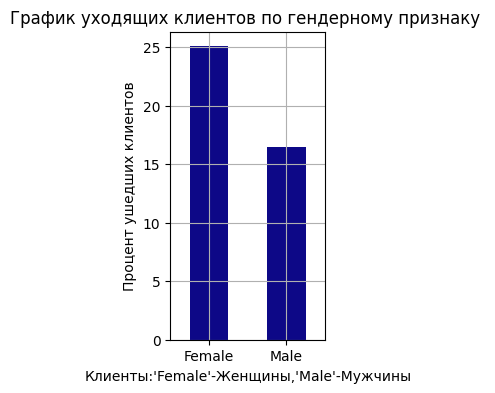

In [112]:
# Посмотрим на зависимость оттока от пола клиента

data=churn_data.groupby(by='Gender')['Exited'].mean()*100
data.plot(
    kind='bar',
    grid=True,
    figsize=(2, 4),
    colormap='plasma',
    title='График уходящих клиентов по гендерному признаку ',
    rot=0,
    xlabel="Клиенты:'Female'-Женщины,'Male'-Мужчины",
    ylabel='Процент ушедших клиентов'  
);

##### Вывод: Видим, что женщины примерно на 10% чаще уходят из банка.

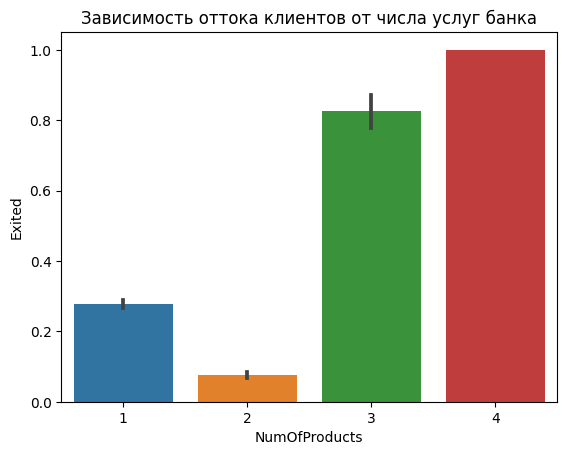

In [113]:
# Посмотрим на зависимость оттока от числа услуг

barplot = sns.barplot(
    data=churn_data,
    x='NumOfProducts',
    y='Exited'
)
barplot.set_title('Зависимость оттока клиентов от числа услуг банка');

##### Вывод: Видим, что наименьший отток нблюдается у клиентов, которые пользуются 2-мя банковскими услугами, затем идут клиенты с одной услугой и практически все клиенты, которые пользуются 3-мя и 4-мя услугами уходят из банка.

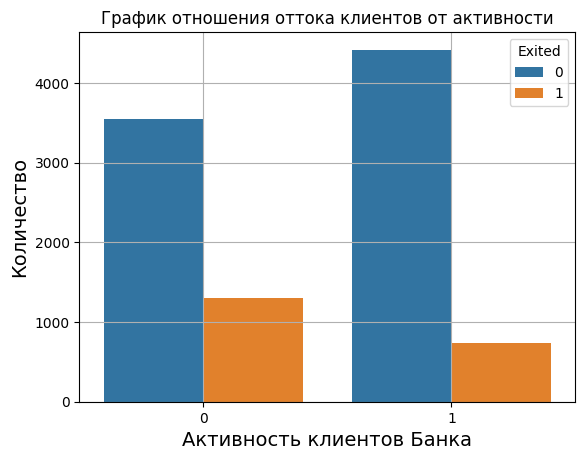

In [114]:
# Посмотрим на зависимость оттока от активности клиентов

data=churn_data.groupby(['IsActiveMember', 'Exited'], as_index=False)['CustomerId'].count()
barplot = sns.barplot(
    data=data,
    x='IsActiveMember',
    y='CustomerId',
    hue='Exited',

)
barplot.set_title('График отношения оттока клиентов от активности');
barplot.set_xlabel('Активность клиентов Банка', fontsize=14);
barplot.set_ylabel('Количество', fontsize=14);
barplot.grid()

##### Вывод: Отток активных клиентов в два раза меньше, чем пассивных. Стоит задуматься об увеличении активности клиентов предлагая им какие-либо бонусы.

In [115]:
# Посмотрим на зависимость оттока в зависимости от страны проживания клиента

choropleth_data=churn_data.groupby(['Geography'],as_index=False)['Exited'].mean()
fig = px.choropleth(
    data_frame=choropleth_data, 
    locations="Geography", 
    locationmode = "country names", 
    color="Exited", 
    range_color=[0,0.5], 
    title='Распределение оттока клиентов по странам', 
    width=800, 
    height=500, 
    color_continuous_scale='Greens' 
)
fig.show()

##### Вывод: Наибольший отток клиентов наблюдается в Германии.

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [116]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [117]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [118]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [119]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

##### Создаем указанные выше признаки

In [120]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGiveAge'] = churn_data['CreditScore'] / churn_data['Age']

In [121]:
# Выведем информацию о признаках

churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509 entries, 7 to 9998
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         2509 non-null   int64  
 1   Gender              2509 non-null   object 
 2   Age                 2509 non-null   int64  
 3   Tenure              2509 non-null   int64  
 4   Balance             2509 non-null   float64
 5   NumOfProducts       2509 non-null   int64  
 6   HasCrCard           2509 non-null   int64  
 7   IsActiveMember      2509 non-null   int64  
 8   EstimatedSalary     2509 non-null   float64
 9   Exited              2509 non-null   int64  
 10  BalanceSalaryRatio  2509 non-null   float64
 11  TenureByAge         2509 non-null   float64
 12  CreditScoreGiveAge  2509 non-null   float64
dtypes: float64(5), int64(7), object(1)
memory usage: 274.4+ KB


In [122]:
# Посмотрим на количество уникальных значений категориального текстового признака Gender

churn_data['Gender'].value_counts()

Gender
Male      1316
Female    1193
Name: count, dtype: int64

##### Перекодируем категориальный текстовый признак Gtnder в числовой бинарный 

In [123]:
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)

In [124]:
# Посмотрим на результат кодирования

churn_data['Gender'].value_counts()

Gender
1    1316
0    1193
Name: count, dtype: int64

##### Выведем основные статистические характеристики созданых признаков

In [125]:
display(f" Минимальное значение признака 'BalanceSalaryRatio' :{churn_data['BalanceSalaryRatio'].min()}")
display(f" Минимальное значение признака 'TenureByAge' :{churn_data['TenureByAge'].min()}")
display(f" Минимальное значение признака 'CreditScoreGiveAge' :{churn_data['CreditScoreGiveAge'].min()}")
display(f" Максимальное значение признака 'BalanceSalaryRatio' :{churn_data['BalanceSalaryRatio'].max()}")
display(f" Мфксимальное значение признака 'TenureByAge' :{churn_data['TenureByAge'].max()}")
display(f" Мфксимальное значение признака 'CreditScoreGiveAge' :{churn_data['CreditScoreGiveAge'].max()}")
display(f" Мода признака 'BalanceSalaryRatio' :{churn_data['BalanceSalaryRatio'].mode()}")
display(f" Мода признака 'TenureByAge' :{churn_data['TenureByAge'].mode()}")
display(f" Мода признака 'CreditScoreGiveAge' :{churn_data['CreditScoreGiveAge'].mode()}")
display(f" Медиана признака 'BalanceSalaryRatio' :{churn_data['BalanceSalaryRatio'].median()}")
display(f" Медиана признака 'TenureByAge' :{churn_data['TenureByAge'].median()}")
display(f" Медиана признака 'CreditScoreGiveAge' :{churn_data['CreditScoreGiveAge'].median()}")

" Минимальное значение признака 'BalanceSalaryRatio' :0.19258177786104777"

" Минимальное значение признака 'TenureByAge' :0.0"

" Минимальное значение признака 'CreditScoreGiveAge' :6.112676056338028"

" Максимальное значение признака 'BalanceSalaryRatio' :10614.655440414508"

" Мфксимальное значение признака 'TenureByAge' :0.5"

" Мфксимальное значение признака 'CreditScoreGiveAge' :46.388888888888886"

" Мода признака 'BalanceSalaryRatio' :0           0.192582\n1           0.222566\n2           0.225549\n3           0.227632\n4           0.237493\n            ...     \n2504      271.981725\n2505      349.521987\n2506      437.980842\n2507     1326.102779\n2508    10614.655440\nName: BalanceSalaryRatio, Length: 2509, dtype: float64"

" Мода признака 'TenureByAge' :0    0.0\nName: TenureByAge, dtype: float64"

" Мода признака 'CreditScoreGiveAge' :0    21.25\nName: CreditScoreGiveAge, dtype: float64"

" Медиана признака 'BalanceSalaryRatio' :1.1972201015354338"

" Медиана признака 'TenureByAge' :0.125"

" Медиана признака 'CreditScoreGiveAge' :16.857142857142858"

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [126]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [127]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [128]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [129]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

##### Выведем описательную статистику тренировочной выборки

In [130]:
X_train.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGiveAge
count,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000,1881.000000
mean,652.770867,0.525784,39.711855,5.057416,119795.559160,1.512493,0.701754,0.500266,101175.716358,9.628504,0.135823,17.611524
std,97.506389,0.499468,10.634044,2.909613,27216.574841,0.609306,0.457610,0.500133,58903.368844,245.145118,0.087306,5.398172
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.000000,0.000000,11.580000,0.192582,0.000000,6.229730
25%,585.000000,0.000000,32.000000,3.000000,102772.670000,1.000000,0.000000,0.000000,49833.500000,0.780291,0.064516,13.731707
50%,651.000000,1.000000,38.000000,5.000000,119657.530000,1.000000,1.000000,1.000000,102428.510000,1.196131,0.128205,16.950000
75%,724.000000,1.000000,45.000000,8.000000,137592.310000,2.000000,1.000000,1.000000,153122.580000,2.433769,0.200000,20.880000
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.000000,1.000000,199970.740000,10614.655440,0.500000,46.388889


##### Т.к. данных у нас достаточно много (более 1000 наблюдений), для проверки на нормальность распределений будем исчпользовать тест Д'Агостино.

In [131]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

data = X_train['EstimatedSalary']

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
if p > alpha:
	print(H0)
else:
	 print(Ha)

Statistics=2553.437, p=0.000
Данные не распределены нормально (мы отвергаем H0)


##### Для нормализации используем нормалтзатор RobustScaler.

In [132]:
# Копируем названия столбцов, которые теряются при использовании fit_transform()

col_names = list(X_train.columns)

# инициализируем нормализатор RobustScaler

r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет

df_r_train = r_scaler.fit_transform(X_train)
df_r_test = r_scaler.fit_transform(X_test)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации

df_r_train = pd.DataFrame(df_r_train, columns=col_names)
df_r_test = pd.DataFrame(df_r_test, columns = col_names)

In [133]:
# инициализируем стандартизатор StandardScaler

s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет

df_s_train = s_scaler.fit_transform(df_r_train)
df_s_test = s_scaler.fit_transform(df_r_test)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации

df_s_train = pd.DataFrame(df_s_train, columns=col_names)
df_s_test = pd.DataFrame(df_s_test, columns = col_names)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

##### Вывод: По условию задачи нам нужно минимизировать как ложноположительные результаты (ошибка | рода) так и ложноотрицательные (ошибка || рода), поэтому мы вибираем в качестве метрики F-меру. Она в полной мере даст нам баланс между точностью (precision) и полнотой (recall).
##### По результу работы метрики достигается максимум, если максимальны обе метрики и минимум, если хотя бы одна из метрик равна 0.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [134]:
# Создаём объект класса LogisticRegression

log_reg_full = linear_model.LogisticRegression(random_state = 42)

# Обучаем модель, минимизируя logloss

log_reg_full.fit(df_s_train, y_train)

LogisticRegression(random_state=42)

In [135]:
# Делаем предсказание класса

y_pred_train = log_reg_full.predict(df_s_train)
y_pred_test = log_reg_full.predict(df_s_test) 

In [136]:
# Рассчитываем значение целевой метрики на тренировочной и тестовой выборках

print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test)))

F1 score train: 0.51
F1 score test: 0.48


##### Вывод: Модель является недообученной, т.к. значение целевой метрики на тестовой выборке 0.48, т.е. меньше 0.5

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [137]:
#Создаём генератор полиномиальных признаков

poly = preprocessing.PolynomialFeatures(degree = 3, include_bias=False)

poly.fit(df_s_train)

#Генерируем полиномиальные признаки для тренировочной выборки

X_train_poly = poly.transform(df_s_train)

#Генерируем полиномиальные признаки для тестовой выборки

X_test_poly = poly.transform(df_s_test)

#Выводим результирующие размерности таблиц

print(X_train_poly.shape)
print(X_test_poly.shape)

(1881, 454)
(628, 454)


In [138]:
#Создаём объект класса LogisticRegression

log_reg_full_poly= linear_model.LogisticRegression(random_state = 42, max_iter = 1000)

#Обучаем модель, минимизируя logloss

log_reg_full_poly.fit(X_train_poly, y_train)

#Делаем предсказание класса

y_pred_train_poly = log_reg_full_poly.predict(X_train_poly)
y_pred_test_poly = log_reg_full_poly.predict(X_test_poly) 

In [139]:
# Рассчитываем значение целевой метрики на тренировочной и тестовой выборках

print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_pred_train_poly)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_pred_test_poly)))

F1 score train: 0.77
F1 score test: 0.64


##### Вывод: Удалось улучшить качество модели, т.к. значения целевой метрики на обоих выборках увеличились

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [140]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки

y_test_proba_pred = log_reg_full_poly.predict_proba(X_test_poly)[:, 1]

# Для удобства завернем numpy-массив в pandas Series

y_test_proba_pred = pd.Series(y_test_proba_pred)

# Создадим списки для хранения значений метрик 

recall_scores = []
precision_scores = []
f1_scores = []

# Задаём значения порогов вероятности

thresholds = np.arange(0.1, 1, 0.05)

# В цикле перебираем значения порогов вероятности

for threshold in thresholds:

    # Делаем предсказание

    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)

    # Рассчитываем метрики и добавляем их в списки

    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

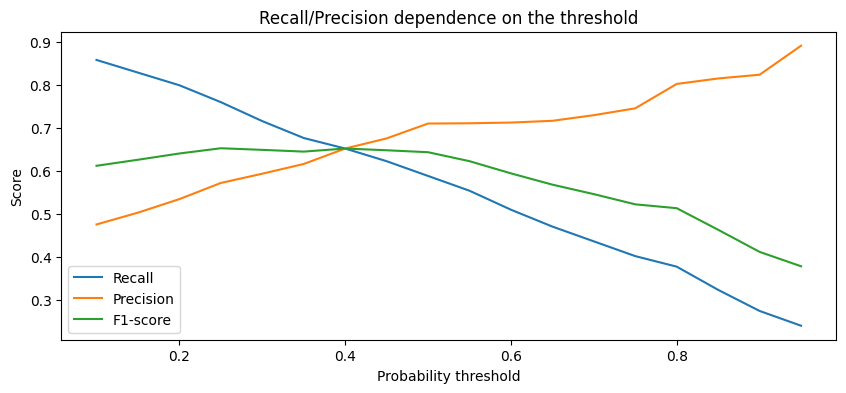

In [141]:
# Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

# Строим линейный график зависимости recall от threshold

ax.plot(thresholds, recall_scores, label='Recall')

# Строим линейный график зависимости precision от threshold

ax.plot(thresholds, precision_scores, label='Precision')


# Строим линейный график зависимости F1 от threshold

ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям

ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

##### График показывает, что оптимальный порог вероятности равен 0.4

In [142]:
# Задаем оптимальный порог вероятности

threshold_opt = 0.4

# Делаем предсказание

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Рассчитываем значение целевой метрики для тестовой выборки

print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))

F1 score test: 0.65


##### Вывод: При оптимизации порога вероятности мы получили максимальное значение метрики для нашей модели.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [143]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [144]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [145]:
# Создаем объект класса дерево решений

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
# Обучаем дерево по алгоритму CART

dt.fit(X_train, y_train)

# Выводим значения метрики для обеих выборок

y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.57


##### Вывод: Сравнив результаты по обеим выборкам, можно сделать вывод, что модель является недообученной, т.к. очень велика разница между значениями метрики для тренировочной и тестовой выборок. Это происходит потому что,  в модели установлены не оптимальные параметры.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [146]:
# Создаем объект класса дерево решений

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=10,
    max_depth=8,
    random_state=42
)

# Обучаем дерево по алгоритму CART

dt.fit(X_train, y_train)

# Выводим значения метрики для обеих выборок

y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.72
Test: 0.64


##### Вывод: По сравнению с полученными ранее, результаты улучшились, но можно еще лучше.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [147]:
# Создаем объект класса случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)

# Обучаем модель

rf.fit(X_train, y_train)

# Выводим значения метрики
 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.74
Test: 0.66


##### Вывод: Качество случайного леса выше чем качество одного дерева. Это видно по значению целевой метрики - значение увеличилось (0.66 против 0.64).

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [148]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки

y_test_proba_pred = rf.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series

y_test_proba_pred = pd.Series(y_test_proba_pred)

# Создадим списки, в которых будем хранить значения метрик

recall_scores = []
precision_scores = []
f1_scores = []

# Задаём значения порогов вероятности

thresholds = np.arange(0.1, 1, 0.05)

# В цикле перебираем значения порогов вероятности

for threshold in thresholds:

    # Делаем предсказание

    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    
    # Рассчитываем метрики и добавляем их в списки

    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\sysadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



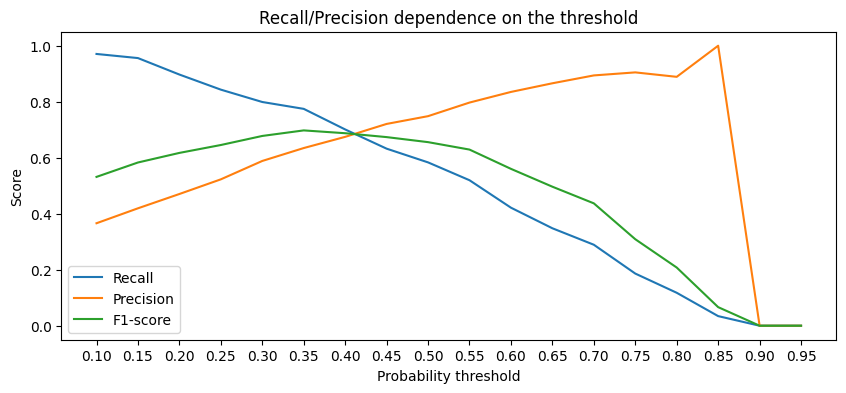

In [149]:
# Визуализируем метрики при различных threshold

fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

# Строим линейный график зависимости recall от threshold

ax.plot(thresholds, recall_scores, label='Recall')

# Строим линейный график зависимости precision от threshold

ax.plot(thresholds, precision_scores, label='Precision')


# Строим линейный график зависимости F1 от threshold

ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям

ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

##### График показывает, что оптимальный порог вероятности равен 0.4

In [150]:
# Задаем оптимальный порог вероятностей

threshold_opt = 0.4

# Делаем предсказание

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

# Рассчитываем значение целевой метрики для тестовой выборки

print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))

F1 score test: 0.69


##### Вывод: Оптимизировав параметры и задав оптимальный порог вероятности, мы получили наилучшее значение целевой метрики для модели случайного леса. Значение метрики равно 0.69, исходя из этого можно сказать, что модель случайного леса является хорошей и справляется с поставленной задачей.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [151]:
# Загружаем данные

data = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# Кодируем категориальные признаки

data['Gender'] = data['Gender'].apply(lambda x: 1 if x=='Male' else 0)

# Добавляем дополнительные признаки

data['BalanceSalaryRatio'] = data['Balance'] / data['EstimatedSalary']
data['TenureByAge'] = data['Tenure'] / data['Age']
data['CreditScoreGiveAge'] = data['CreditScore'] / data['Age']

##### Ранее было доказано, что лучшая модель для решения данной задачи - это случайный лес. Поэтому будем строить прогнозы с помощью модели случайный лес. Для этой модели не требуется н стандартизация, ни нормализация.

In [152]:
# Предсказание с помощю модели случайный лес

y_pred = rf.predict(data)
y_pred

array([1], dtype=int64)

In [153]:
# Предскажем вероятность оттока клиента

rf.predict_proba(data)

array([[0.38570043, 0.61429957]])

##### Вывод: Модель случайного леса предсказывает, что Василий покинет банк. Кроме того по предсказанная вероятность того, что клиент покинет банк равна 0.61 против 0.39. Значит Василий все таки уйдет из этого банка, поэтому ему необходимо сделать какое-то предложение. что бы заинтересовать его остаться.